# Add_feature all
* 추가로 만든(각각 magnitude에서 마이너스한) 변수만 사용해서 진행
* category_features 사용위해 lgb.train사용
* 제출결과 : 34.1706082219(에러수정전)/16.4869865283(수정후)
* overfitting이 심하게된듯

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
import lightgbm as lgb

In [2]:
#colab용
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = "/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/data/" #colab
# path = "./data/" #local
train_df = pd.read_csv(path+'train.csv',index_col=0)
test_df = pd.read_csv(path+'test.csv',index_col=0)
sample_submission_df = pd.read_csv(path+'sample_submission.csv',index_col=0)
pd.options.display.max_columns = 30

In [0]:
train_cols = list(train_df.columns)
test_cols = list(test_df.columns)
train_cols.remove('fiberID')
test_cols.remove('fiberID')

## DATA Setting

In [0]:
column_number = {}
number_columns = {}
for i, column in enumerate(sample_submission_df.columns):
    column_number[column] = i
    number_columns[i] = column
    
    
def to_number(x, dic):
    return dic[x]

train_df['type_num'] = train_df['type'].apply(lambda x: to_number(x, column_number))


In [0]:
def add_minus_feature(data,test = False):
    from itertools import combinations
    n = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
        for combi in list(combinations(selected,2)):
            name_1st = str.split(combi[0],'_')[1]
            name_2nd = str.split(combi[1],'_')[1]
            data[mag+"_"+name_1st+"-"+name_2nd] = data[combi[0]]-data[combi[1]]
        n=count
    return data

In [0]:
train_df = add_minus_feature(train_df)
test_df = add_minus_feature(test_df,True)

In [0]:
train_X = train_df.drop(columns=train_cols, axis=1)
train_y = train_df['type_num']
test_X = test_df.drop(columns=test_cols, axis=1)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=42,stratify = train_y)

In [0]:
train_ds = lgb.Dataset(X_train, label = y_train, categorical_feature=['fiberID'])
test_ds = lgb.Dataset(X_test, label = y_test, categorical_feature=['fiberID']) 

In [0]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': train_y.nunique(),
    'metric': {'multi_logloss','multi_logloss'},
    'num_leaves': 25,
    'learning_rate': 0.005,
    'max_depth' : 12,
    'random_state' : 42
}

## Modeling

In [12]:
evaluation_results = {}
lgmb_model = lgb.train(params, train_ds,num_boost_round= 20000, 
                       valid_sets = [train_ds,test_ds], valid_names=['Train', 'Test'],
                       evals_result=evaluation_results,
                       verbose_eval=100, early_stopping_rounds=100)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	Train's multi_logloss: 1.01229	Test's multi_logloss: 1.01437
[200]	Train's multi_logloss: 0.570942	Test's multi_logloss: 0.573105
[300]	Train's multi_logloss: 0.336338	Test's multi_logloss: 0.338348
[400]	Train's multi_logloss: 0.201238	Test's multi_logloss: 0.203079
[500]	Train's multi_logloss: 0.121219	Test's multi_logloss: 0.122888
[600]	Train's multi_logloss: 0.0732575	Test's multi_logloss: 0.0747554
[700]	Train's multi_logloss: 0.0443483	Test's multi_logloss: 0.0456802
[800]	Train's multi_logloss: 0.0268703	Test's multi_logloss: 0.0280479
[900]	Train's multi_logloss: 0.0162862	Test's multi_logloss: 0.0173233
[1000]	Train's multi_logloss: 0.00987452	Test's multi_logloss: 0.0107853
[1100]	Train's multi_logloss: 0.00598825	Test's multi_logloss: 0.00677
[1200]	Train's multi_logloss: 0.00363191	Test's multi_logloss: 0.00430856
[1300]	Train's multi_logloss: 0.00220293	Test's multi_logloss: 0.00279492
[1400]	Train's mul

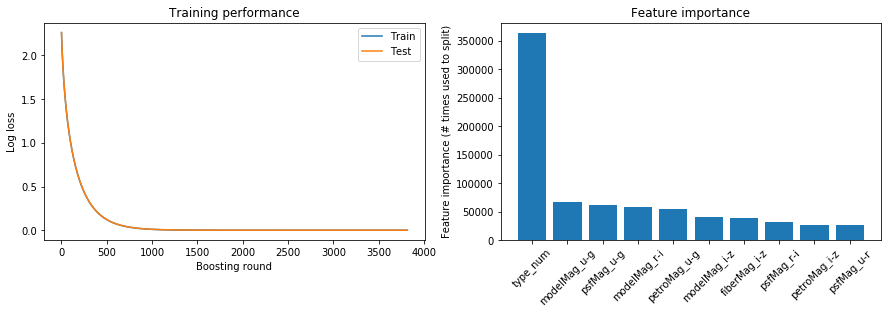

In [16]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['multi_logloss'], label='Train')
axs[0].plot(evaluation_results['Test']['multi_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': lgmb_model.feature_name(), 
                            'importance': lgmb_model.feature_importance()}).sort_values('importance', ascending=False).head(10)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')
plt.xticks(rotation=45)

plt.show()

In [0]:
train_y_pred = lgmb_model.predict(X_test)

In [0]:
real_y_pred = lgmb_model.predict(test_X)

In [19]:
train_y_pred.shape

(59998, 19)

In [20]:
train_y_pred

array([[1.27917531e-09, 1.62156978e-09, 5.16809930e-10, ...,
        8.34875689e-10, 2.28881005e-10, 2.79154062e-09],
       [1.63762583e-09, 4.04748640e-09, 7.38016459e-10, ...,
        1.78961742e-09, 3.23150232e-10, 3.88424840e-09],
       [8.15959964e-10, 1.12579495e-09, 3.58455225e-10, ...,
        5.79674700e-10, 1.60909641e-10, 1.94657707e-09],
       ...,
       [7.12588701e-10, 9.83171722e-10, 3.12993234e-10, ...,
        5.05351812e-10, 1.38517411e-10, 1.69997160e-09],
       [7.23503361e-10, 9.83171716e-10, 3.13441477e-10, ...,
        5.05533692e-10, 1.38517411e-10, 1.83448340e-09],
       [2.24000938e-09, 3.08602588e-09, 9.87373282e-10, ...,
        1.59289221e-09, 4.42036905e-10, 5.30862037e-09]])

In [21]:
#log_loss
log_loss(y_test,train_y_pred,labels= list(set(y_test)))

0.00016047749420568518

In [22]:
lgmb_model.feature_importance()

array([   448, 363809,  61077,  25843,  21804,  12791,  13158,  15314,
        15183,  31987,  15880,  24678,  16870,  14855,  11727,   7001,
        24368,  13488,  15241,  21050,  24815,  38570,  54474,  14239,
        17468,  10200,  20010,   7239,   6465,  21505,   5840,  27249,
        66811,  17392,  15192,  13166,  23196,  20496,  15826,  57714,
        15926,  40348])

### feature_importance

In [23]:
pi_df = pd.DataFrame(lgmb_model.feature_importance(), index= train_X.columns,columns= ['importance']).sort_values('importance',ascending = False)
pi_df.head(10)

,importance
type_num,363809
modelMag_u-g,66811
psfMag_u-g,61077
modelMag_r-i,57714
petroMag_u-g,54474
modelMag_i-z,40348
fiberMag_i-z,38570
psfMag_r-i,31987
petroMag_i-z,27249
psfMag_u-r,25843


### 예측결과에 대해
* 12번이 모두 6번으로 몰림
중간예측 : 0,2,7,11
망한예측 : 12,17

In [0]:
cm_result = pd.DataFrame(confusion_matrix(y_test,np.argmax(train_y_pred,axis = 1)))

In [25]:
cm_result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,648,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1952,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,769,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,4386,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,4050,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,11204,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1396,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,14904,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0


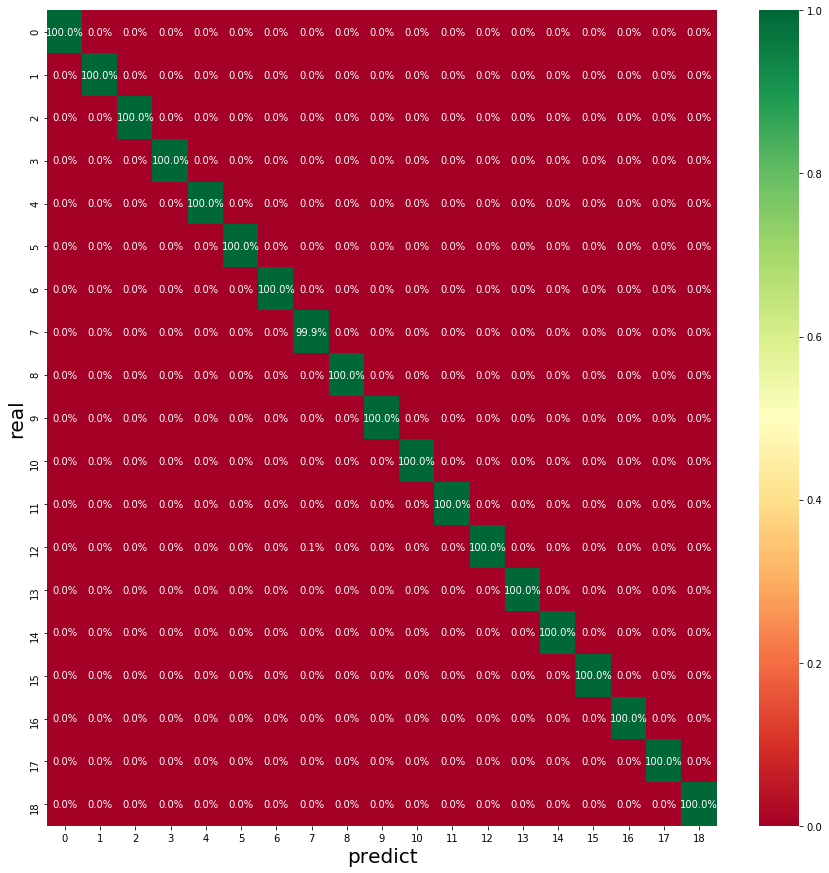

In [26]:
plt.figure(figsize =(15,15))
sns.heatmap(cm_result/np.sum(cm_result),annot = True, cmap ='RdYlGn',fmt='.1%')
plt.ylabel("real",fontsize=20)
plt.xlabel("predict",fontsize=20)
plt.show()

# REAL

In [0]:
train_ds = lgb.Dataset(train_X, label = train_y, categorical_feature=['fiberID'])

In [28]:
lgmb_model = lgb.train(params, train_ds,num_boost_round= 4000, verbose_eval=100)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [0]:
y_pred = lgmb_model.predict(test_X)

In [30]:
y_pred

array([[1.33571740e-09, 9.99999262e-01, 6.39998528e-07, ...,
        1.29117653e-09, 2.62906172e-10, 3.11626876e-09],
       [4.77611384e-09, 9.99999660e-01, 6.48178488e-09, ...,
        4.61072135e-09, 9.38418841e-10, 1.13290195e-08],
       [3.21562469e-08, 4.35765984e-08, 9.99978759e-01, ...,
        2.79280647e-08, 6.31810408e-09, 7.62414154e-08],
       ...,
       [3.84087493e-09, 9.99999845e-01, 4.71491839e-09, ...,
        2.47585951e-09, 6.75877333e-10, 8.30913597e-09],
       [7.87793130e-09, 9.99999598e-01, 1.02314794e-08, ...,
        5.36887466e-09, 1.46666836e-09, 2.13683398e-08],
       [3.80796367e-09, 9.99999031e-01, 4.77890954e-09, ...,
        2.51047672e-09, 6.93185570e-10, 8.42200227e-09]])

In [31]:
real_y_pred

array([[1.86464603e-09, 9.99999815e-01, 5.16471481e-08, ...,
        1.77905833e-09, 3.69200807e-10, 4.33848734e-09],
       [6.56183276e-09, 9.99999523e-01, 8.73010863e-09, ...,
        6.24273243e-09, 1.29497709e-09, 1.55465229e-08],
       [1.11712320e-06, 1.53381418e-06, 9.93465146e-01, ...,
        9.70832675e-07, 2.20459842e-07, 2.63023056e-06],
       ...,
       [5.58185504e-09, 9.99999705e-01, 7.00176163e-09, ...,
        3.74301838e-09, 1.02615650e-09, 1.26549906e-08],
       [1.12249498e-08, 9.99999423e-01, 1.35267232e-08, ...,
        7.23188207e-09, 2.01185738e-09, 2.87929097e-08],
       [5.92929680e-09, 9.99996915e-01, 6.99376777e-09, ...,
        3.74138030e-09, 1.04022963e-09, 1.26452997e-08]])

In [0]:
submission = pd.DataFrame(data=y_pred, columns=sample_submission_df.columns, index=sample_submission_df.index)
submission.to_csv('submission.csv', index=True)

In [0]:
# #제출변경
# submission = pd.DataFrame(data=train_y_pred, columns=sample_submission_df.columns, index=sample_submission_df.index)
# submission.to_csv('submission.csv', index=True)